# The goal of this file is to postporcess the prediction of test set to find the impact of # of snps on prediction...

In [1]:
# First find the # of SNPs from the test dataset
from pathlib import Path

import pandas as pd


In [2]:

input_datapath="/proj/bmfm/datasets/omics/genome/finetune_datasets/promoter_prediction/DNA_BERT2/snpified_v1/snp_genome/"
df_test_data = pd.read_csv(Path(input_datapath) / "test.csv")
print(df_test_data.shape[0], df_test_data.head(2))

print(df_test_data['label'].value_counts())

# Get the predictions from the model...
model_predictions = pd.read_csv("/proj/bmfm/users/sanjoy/benchmarking/modernbert_wo_lora_refsnp_v3.31batch32_lr0.0001_pe128_wd0.01_batch_dump/promoter_dnabert2_snpified_v1_snp_genome/lightning_logs/version_7/test_label_iteration_0.csv")

print(model_predictions.head(20))
print(model_predictions['label_label'].value_counts())

5788                                              mut_seq  label
0  CAGGATCCACACATGGCCATGCCCCGCTGCTCCGAGAGAGGGGCCA...      1
1  AACCAAGGTTGTGCCGGGCCCTCCTGGAGCTGGGTCAGCGGGGACA...      1
label
0    2935
1    2853
Name: count, dtype: int64
    Unnamed: 0  label_prediction  label_label  0_logits  1_logits
0            0                 1            1 -2.363281  2.435547
1            1                 1            1 -3.048828  3.162109
2            2                 1            1 -3.660156  3.773438
3            3                 1            1 -2.123047  2.173828
4            4                 1            1 -3.167969  3.271484
5            5                 1            1 -1.026367  1.080078
6            6                 1            1 -3.931641  4.109375
7            7                 1            1 -3.326172  3.421875
8            8                 1            1 -3.888672  4.019531
9            9                 1            1 -2.462891  2.478516
10          10                 1     

Average percentage of variation(300): 1.04%
5788 0 141
Number of wrong Prediction on the model_predictions: 146
Combined data after predictions:                                              mut_seq  label  snp_count  \
0  CAGGATCCACACATGGCCATGCCCCGCTGCTCCGAGAGAGGGGCCA...      1          0   
1  AACCAAGGTTGTGCCGGGCCCTCCTGGAGCTGGGTCAGCGGGGACA...      1          1   

   wrong_prediction  label_prediction  
0             False                 1  
1             False                 1  
SNP Counts:
 snp_count
0      1285
1      1502
2      1073
3       651
4       364
       ... 
84        1
86        1
87        1
121       1
141       1
Name: error, Length: 67, dtype: int64


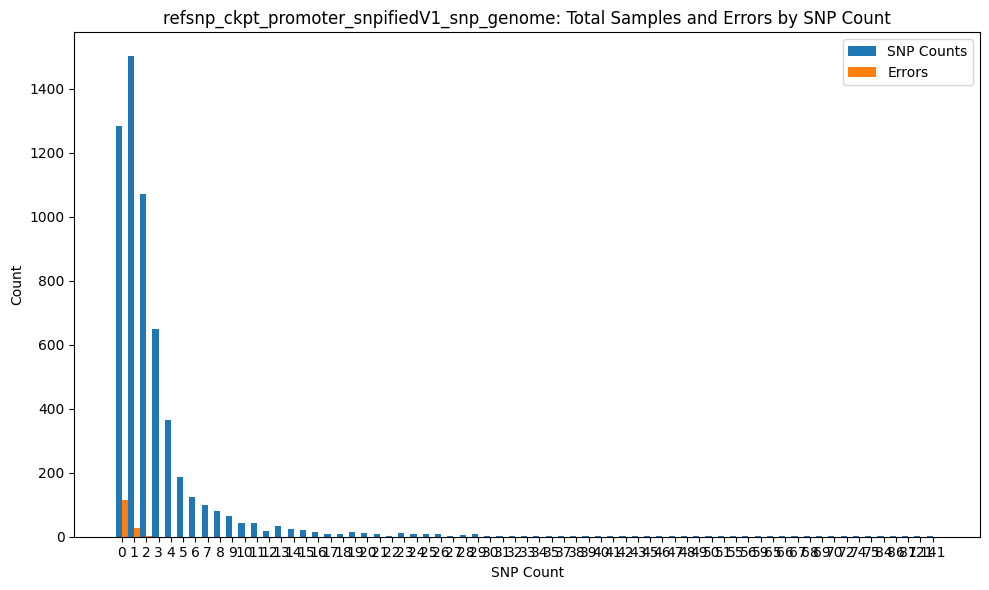

error_counts:  [115  28   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0]


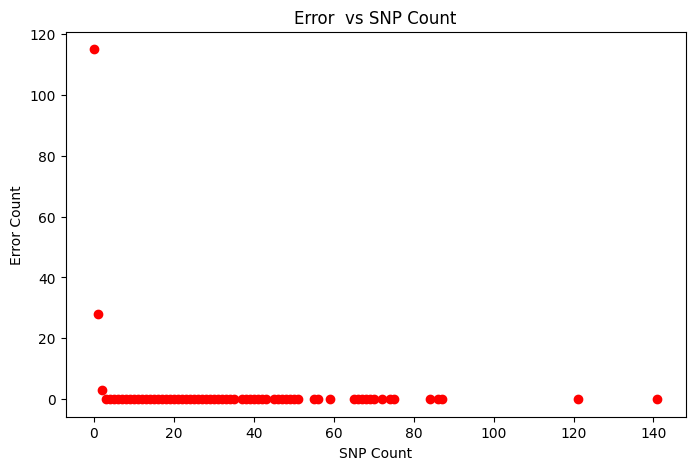

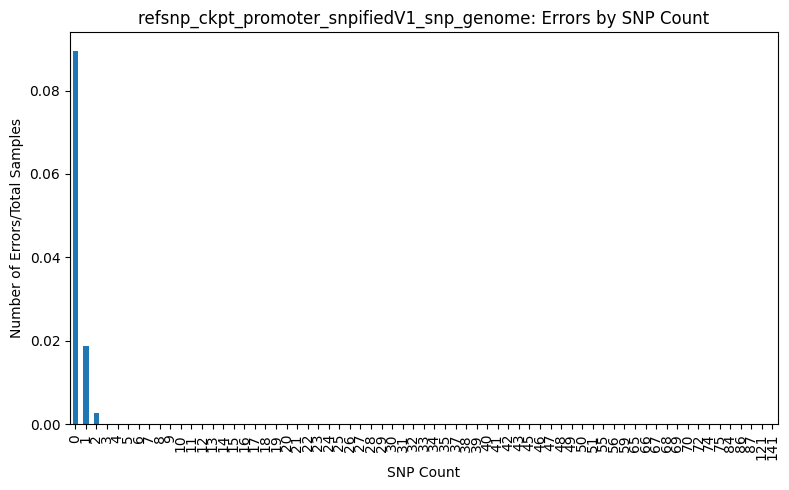

In [ ]:
def count_variation_percent_for_list(sequences):
    snp_ct_seqs = [sum([x not in 'ACGTN' for x in sequence])  for sequence in sequences ]
    len_seqs = [len(sequence) for sequence in sequences ]
    return snp_ct_seqs, len_seqs

def plot_errors_by_snp_count(df_test_data, model_predictions, title=""):
    # First find the snp_counts for each sequence... 
    snp_ct_seqs, len_seqs = count_variation_percent_for_list(df_test_data.iloc[:,0])
    var_percent1 = [snp_ct/length for snp_ct, length in zip(snp_ct_seqs, len_seqs)]
    print("Average percentage of variation(300): %.2f%%" % (sum(var_percent1)/len(var_percent1)*100))

    var_percent1 = snp_ct_seqs
    print(len(var_percent1), min(var_percent1), max(var_percent1))

    df_test_data['snp_count'] = var_percent1
    # convert this col to int
    df_test_data['snp_count'] = df_test_data['snp_count'].astype(int)   
    #print(df_test_data.head(2))
    
    # Check if the labels match
    assert all(df_test_data['label'] == model_predictions['label_label']), "Labels do not match"

    # Find the ones where prediction is wrong
    df_test_data['wrong_prediction'] = model_predictions['label_prediction'] != model_predictions['label_label'] 

    print("Number of wrong Prediction on the model_predictions:", df_test_data['wrong_prediction'].sum())   
    #print(df_test_data.head(2))
    
    df_test_data['label_prediction'] = model_predictions['label_prediction']    
    print("Combined data after predictions:", df_test_data.head(2)) 
    
    import matplotlib.pyplot as plt

    # Calculate errors
    df_test_data['error'] = df_test_data['label'] != df_test_data['label_prediction']

    # Group by snp_count and count errors
    error_counts = df_test_data.groupby('snp_count')['error'].sum()
    snp_counts = df_test_data.groupby('snp_count')['error'].count()
    print("SNP Counts:\n", snp_counts)

    # Plot error counts and snp counts side by side     
    
    import numpy as np

    # Indices for x-axis
    x = np.arange(len(error_counts))

    plt.figure(figsize=(10, 6))
    bar_width = 0.5

    plt.bar(x - bar_width/2, snp_counts, width=bar_width, label='SNP Counts')
    plt.bar(x + bar_width/2, error_counts, width=bar_width, label='Errors')

    plt.xlabel('SNP Count')
    plt.ylabel('Count')
    #plt.ylim(0, 200)  # Set y-axis limit to 200
    plt.title(title+'Total Samples and Errors by SNP Count')
    plt.xticks(x, error_counts.index)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Do a scatter plot of error rate vs snp count
    # Scatter plot of error rate vs snp count
    plt.figure(figsize=(8, 5))
    print("error_counts: ", error_counts.values)
    plt.scatter(error_counts.index, error_counts, color='red')
    plt.xlabel('SNP Count')
    plt.ylabel('Error Count')
    plt.title('Error  vs SNP Count')
    #plt.xlim(0, 200)  # Optional: set x-axis limit to 200
    #plt.tight_layout()
    plt.show()
    
    #Normalize error counts by total counts per SNP count
    error_counts_normalized = error_counts / snp_counts

    # Plot
    plt.figure(figsize=(8, 5))
    error_counts_normalized.plot(kind='bar')
    plt.xlabel('SNP Count')
    plt.ylabel('Number of Errors/Total Samples')
    plt.title(title+'Errors by SNP Count')
    plt.tight_layout()
    plt.show()


plot_errors_by_snp_count(df_test_data, model_predictions, "refsnp_ckpt_promoter_snpifiedV1_snp_genome: ")


5788                                               refsnp  label
0  CAGGATCCACACATGGCCATGCCCCGCTGCTCCGAGAGAGGGGCCA...      1
1  AACCAAGGTTGTGCCGGGCCCTCCTGGAGCTGGGTCAGCGGGGACA...      1
label
0    2935
1    2853
Name: count, dtype: int64
    Unnamed: 0  label_prediction  label_label  0_logits  1_logits
0            0                 1            1 -3.357422  3.533203
1            1                 1            1 -2.980469  3.052734
2            2                 1            1 -3.146484  3.267578
3            3                 1            1 -3.021484  3.181641
4            4                 1            1 -2.814453  2.884766
5            5                 1            1 -2.148438  2.150391
6            6                 1            1 -3.117188  3.218750
7            7                 1            1 -3.849609  3.986328
8            8                 1            1 -3.845703  4.054688
9            9                 1            1 -3.843750  4.070312
10          10                 1     

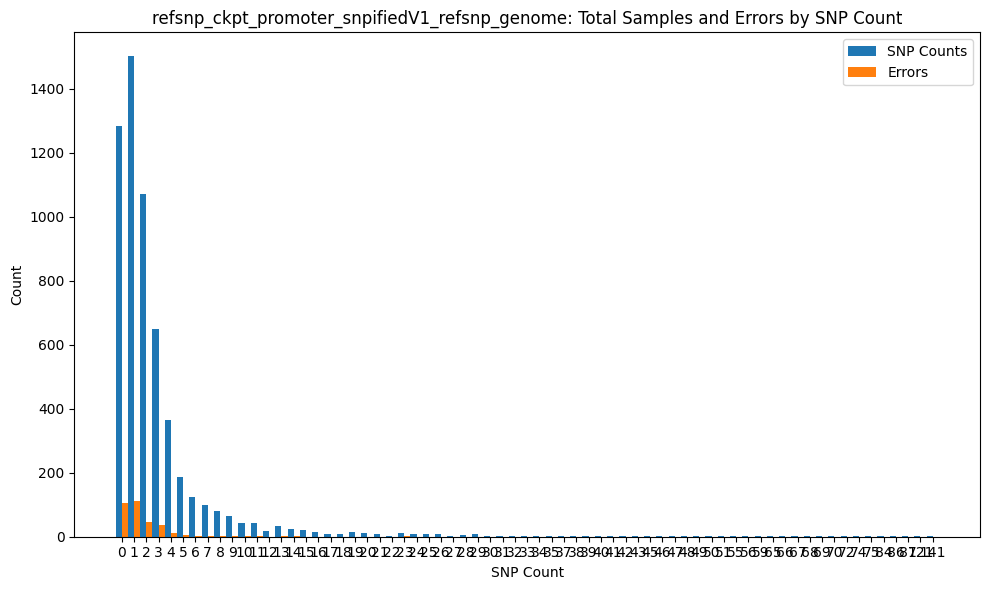

error_counts:  snp_count
0      105
1      112
2       46
3       36
4       12
      ... 
84       0
86       0
87       0
121      0
141      0
Name: error, Length: 67, dtype: int64


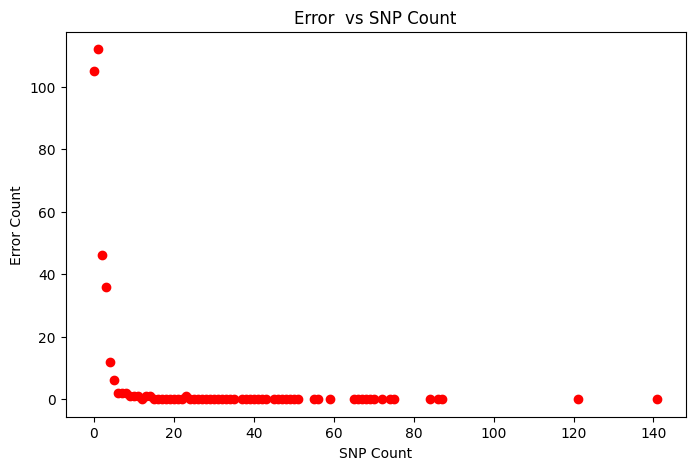

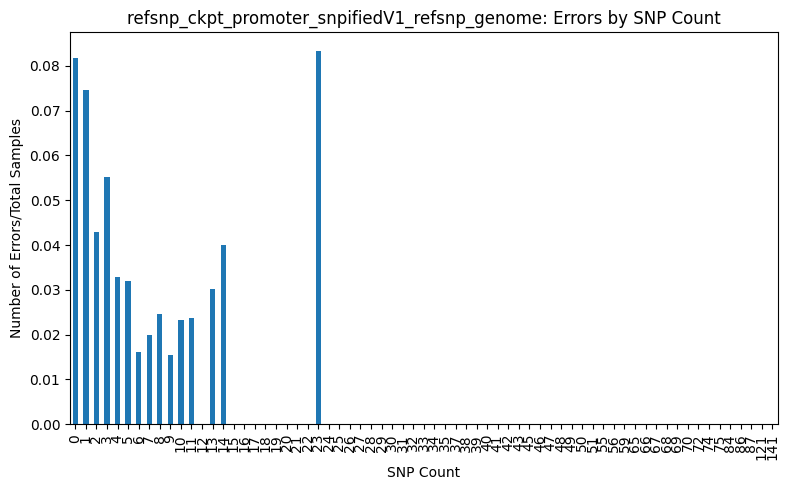

In [25]:

input_datapath="/proj/bmfm/datasets/omics/genome/finetune_datasets/promoter_prediction/DNA_BERT2/snpified_v1/refsnp_genome/"
df_test_data = pd.read_csv(Path(input_datapath) / "test.csv")
print(df_test_data.shape[0], df_test_data.head(2))

print(df_test_data['label'].value_counts())

model_predictions = pd.read_csv("/proj/bmfm/users/sanjoy/benchmarking/modernbert_wo_lora_refsnp_v3.31batch32_lr0.0001_pe128_wd0.01_batch_dump/promoter_dnabert2_snpified_v1_refsnp_genome/lightning_logs/version_6/test_label_iteration_0.csv")

print(model_predictions.head(20))
print(model_predictions['label_label'].value_counts())

plot_errors_by_snp_count(df_test_data, model_predictions, "refsnp_ckpt_promoter_snpifiedV1_refsnp_genome: ")


# Do the same plots for snpified v3...

5788                                              mut_seq  label
0  CAGGATCCACACATGGCCATGCCCCGCTGCTCCGAGAGAGGGGCCA...      1
1  AACCAAGGTTGTGCCGGGCCCTCCTGGAGCTGGGTCAGCGGGGACA...      1
label
0    2935
1    2853
Name: count, dtype: int64
    Unnamed: 0  label_prediction  label_label  0_logits  1_logits
0            0                 1            1 -3.285156  3.490234
1            1                 1            1 -2.890625  3.074219
2            2                 1            1 -2.669922  2.792969
3            3                 1            1 -2.818359  2.966797
4            4                 1            1 -2.867188  3.035156
5            5                 1            1 -2.009766  2.103516
6            6                 1            1 -2.757812  2.900391
7            7                 1            1 -3.109375  3.546875
8            8                 1            1 -3.830078  4.074219
9            9                 1            1 -3.183594  3.332031
10          10                 1     

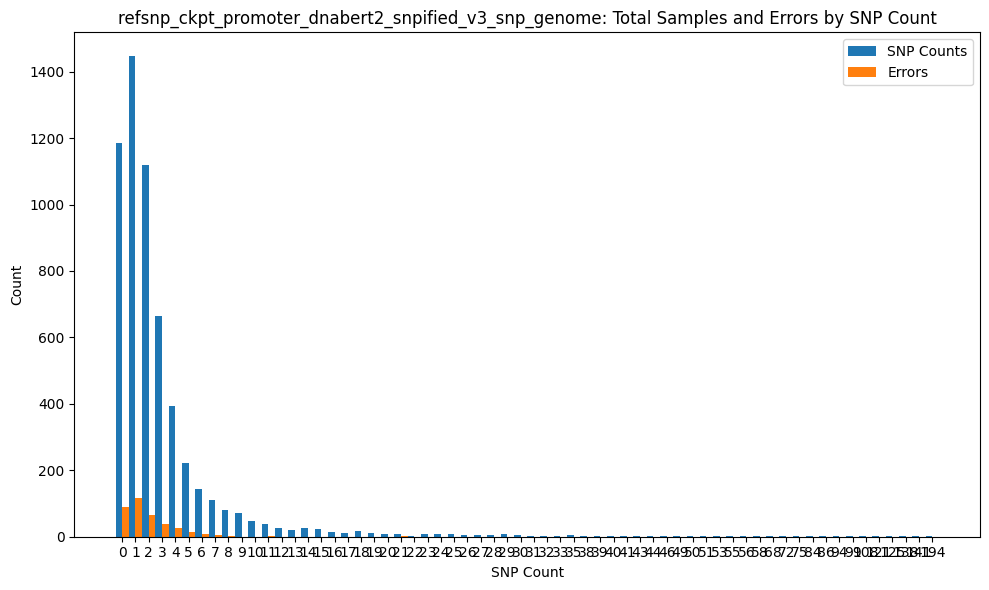

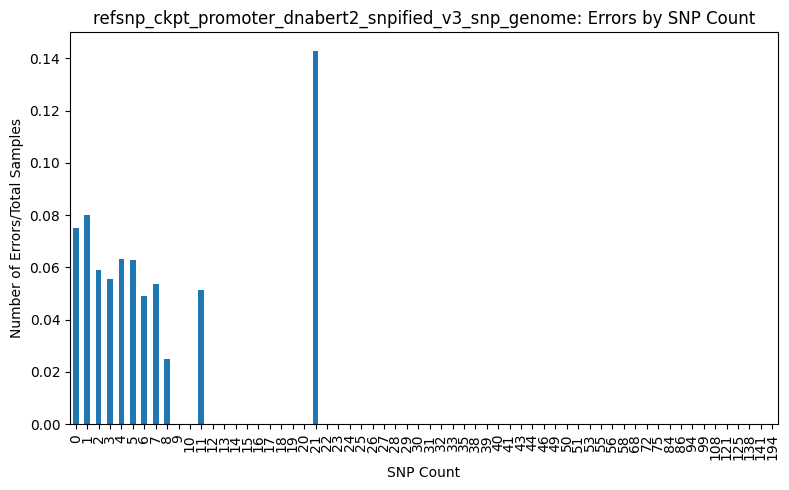

In [ ]:

input_datapath="/proj/bmfm/datasets/omics/genome/finetune_datasets/promoter_prediction/DNA_BERT2/snpified_v3/snp_genome/"
df_test_data = pd.read_csv(Path(input_datapath) / "test.csv")
print(df_test_data.shape[0], df_test_data.head(2))

print(df_test_data['label'].value_counts())

model_predictions = pd.read_csv("/proj/bmfm/users/sanjoy/benchmarking/modernbert_wo_lora_refsnp_v3.31batch32_lr0.0001_pe128_wd0.01_batch_dump/promoter_dnabert2_snpified_v3_snp_genome/lightning_logs/version_7/test_label_iteration_0.csv")

print(model_predictions.head(20))
print(model_predictions['label_label'].value_counts())

plot_errors_by_snp_count(df_test_data, model_predictions, "refsnp_ckpt_promoter_dnabert2_snpified_v3_snp_genome: ")


5788                                               refsnp  label
0  CAGGATCCACACATGGCCATGCCCCGCTGCTCCGAGAGAGGGGCCA...      1
1  AACCAAGGTTGTGCCGGGCCCTCCTGGAGCTGGGTCAGCGGGGACA...      1
label
0    2935
1    2853
Name: count, dtype: int64
    Unnamed: 0  label_prediction  label_label  0_logits  1_logits
0            0                 1            1 -2.880859  2.535156
1            1                 1            1 -2.490234  2.128906
2            2                 1            1 -2.455078  2.107422
3            3                 1            1 -2.960938  2.615234
4            4                 1            1 -2.589844  2.214844
5            5                 1            1 -2.195312  1.930664
6            6                 1            1 -2.541016  2.085938
7            7                 1            1 -1.617188  1.471680
8            8                 1            1 -3.287109  2.798828
9            9                 1            1 -3.115234  2.689453
10          10                 1     

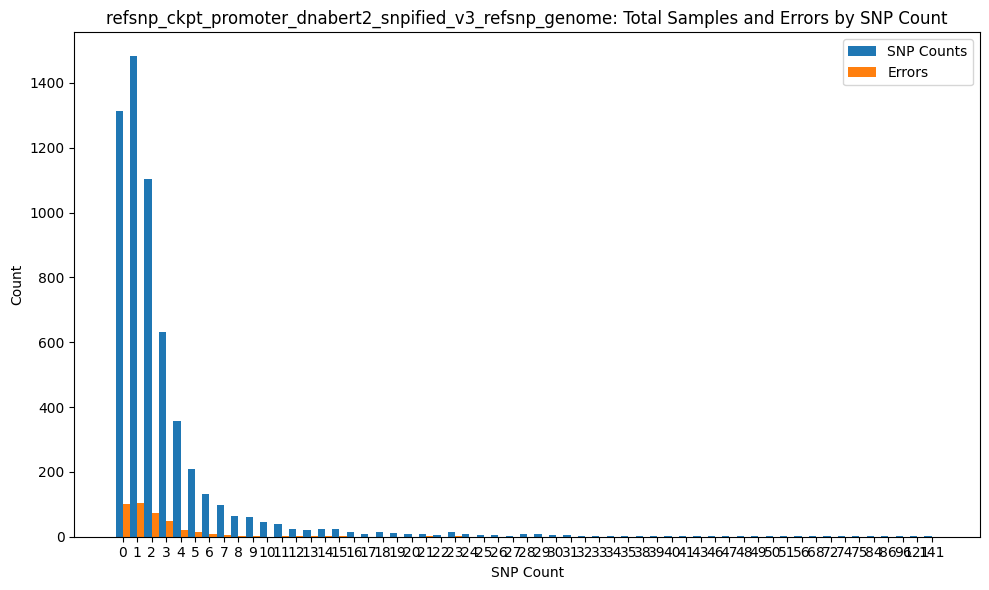

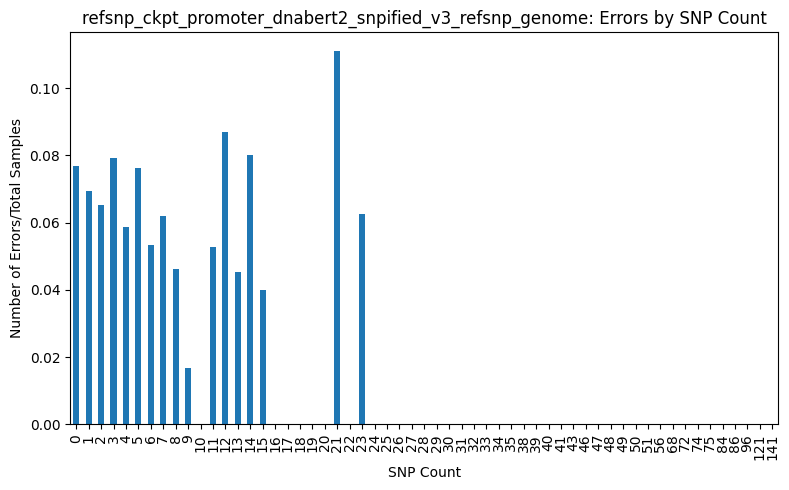

In [10]:
import pandas as pd

input_datapath="/proj/bmfm/datasets/omics/genome/finetune_datasets/promoter_prediction/DNA_BERT2/snpified_v3/refsnp_genome/"
df_test_data = pd.read_csv(Path(input_datapath) / "test.csv")
print(df_test_data.shape[0], df_test_data.head(2))

print(df_test_data['label'].value_counts())

model_predictions = pd.read_csv("/proj/bmfm/users/sanjoy/benchmarking/modernbert_wo_lora_refsnp_v3.31batch32_lr0.0001_pe128_wd0.01_batch_dump/promoter_dnabert2_snpified_v3_refsnp_genome/lightning_logs/version_6/test_label_iteration_0.csv")

print(model_predictions.head(20))
print(model_predictions['label_label'].value_counts())

plot_errors_by_snp_count(df_test_data, model_predictions, "refsnp_ckpt_promoter_dnabert2_snpified_v3_refsnp_genome: ")


In [ ]:
import pandas as pd

input_datapath="/proj/bmfm/datasets/omics/genome/finetune_datasets/promoter_prediction/DNA_BERT2/snpified_v3/refsnp_genome/"
df_test_data = pd.read_csv(Path(input_datapath) / "test.csv")
print(df_test_data.shape[0], df_test_data.head(2))

print(df_test_data['label'].value_counts())

model_predictions = pd.read_csv("/proj/bmfm/users/sanjoy/benchmarking/modernbert_wo_lora_refsnp_v3.31batch32_lr0.0001_pe128_wd0.01_batch_dump/promoter_dnabert2_snpified_v3_refsnp_genome/lightning_logs/version_6/test_label_iteration_0.csv")

print(model_predictions.head(20))
print(model_predictions['label_label'].value_counts())

plot_errors_by_snp_count(df_test_data, model_predictions, "refsnp_ckpt_promoter_dnabert2_snpified_v3_refsnp_genome: ")




In [ ]:
# Check if the labels match
assert all(df_test_data['label'] == model_predictions['label_label']), "Labels do not match"

# Find the ones where prediction is wrong
df_test_data['wrong_prediction'] = model_predictions['label_prediction'] != model_predictions['label_label'] 

print(df_test_data['wrong_prediction'].sum())    
print(df_test_data.head(2))

146
                                             mut_seq  label  snp_count  \
0  CAGGATCCACACATGGCCATGCCCCGCTGCTCCGAGAGAGGGGCCA...      1          0   
1  AACCAAGGTTGTGCCGGGCCCTCCTGGAGCTGGGTCAGCGGGGACA...      1          1   

   wrong_prediction  
0             False  
1             False  


In [9]:
df_test_data['label_prediction'] = model_predictions['label_prediction']    
print(df_test_data.head(2))

                                             mut_seq  label  snp_count  \
0  CAGGATCCACACATGGCCATGCCCCGCTGCTCCGAGAGAGGGGCCA...      1          0   
1  AACCAAGGTTGTGCCGGGCCCTCCTGGAGCTGGGTCAGCGGGGACA...      1          1   

   wrong_prediction  label_prediction  
0             False                 1  
1             False                 1  


SNP Counts:
 snp_count
0      1285
1      1502
2      1073
3       651
4       364
       ... 
84        1
86        1
87        1
121       1
141       1
Name: error, Length: 67, dtype: int64


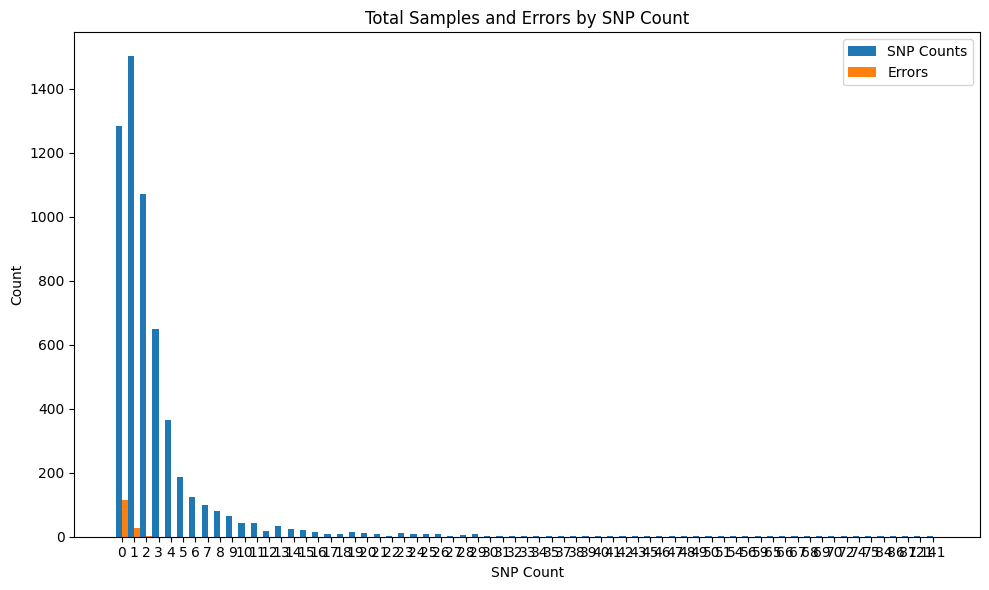

In [ ]:

# Calculate errors
df_test_data['error'] = df_test_data['label'] != df_test_data['label_prediction']

# Group by snp_count and count errors
error_counts = df_test_data.groupby('snp_count')['error'].sum()
snp_counts = df_test_data.groupby('snp_count')['error'].count()
print("SNP Counts:\n", snp_counts)

# Plot error counts and snp counts side by side     
import matplotlib.pyplot as plt
import numpy as np

# Indices for x-axis
x = np.arange(len(error_counts))

plt.figure(figsize=(10, 6))
bar_width = 0.5

plt.bar(x - bar_width/2, snp_counts, width=bar_width, label='SNP Counts')
plt.bar(x + bar_width/2, error_counts, width=bar_width, label='Errors')

plt.xlabel('SNP Count')
plt.ylabel('Count')
#plt.ylim(0, 200)  # Set y-axis limit to 200
plt.title('Total Samples and Errors by SNP Count')
plt.xticks(x, error_counts.index)
plt.legend()
plt.tight_layout()
plt.show()




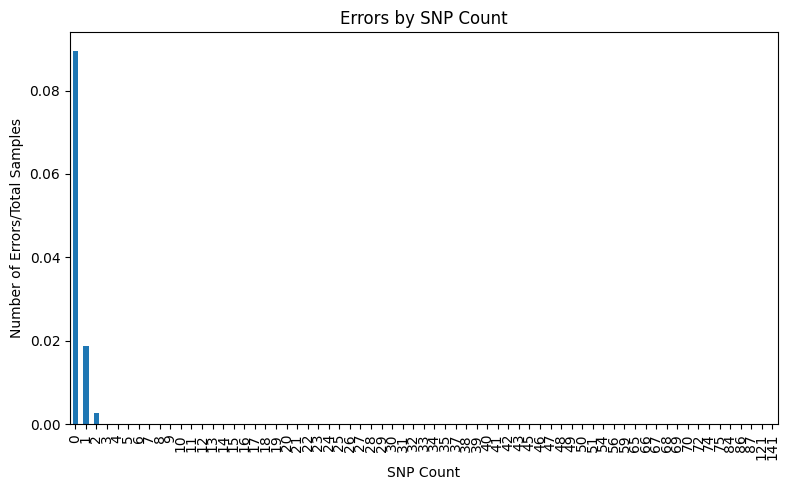

In [12]:

#Normalize error counts by total counts per SNP count
error_counts_normalized = error_counts / snp_counts

# Plot
plt.figure(figsize=(8, 5))
error_counts_normalized.plot(kind='bar')
plt.xlabel('SNP Count')
plt.ylabel('Number of Errors/Total Samples')
plt.title('Errors by SNP Count')
plt.tight_layout()
plt.show()